<a href="https://colab.research.google.com/github/MattiaVerticchio/PersonalProjects/blob/master/CancerClassification/RNAseqCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer classification

> [Italiano]() / **English**
>
> **Abstract**
>
> The objective of this project is to identify what type of cancer a patient has by analyzing his/her RNA sequencing data. There are 44 features in the dataset and 5 possible classes of oncologic diseases to choose from. We’ll explore different statistical and machine learning models using PyCaret as the main framework, with Scikit-Learn, XGBoost, and Microsoft LightGBM as backends. The benchmark is a paper published in 2019 on the Journal of Medical Imaging and Health Informatics. The results are in line with the paper, with slightly better accuracy and Cohen’s Kappa scores.


The 44 features `gene_XX` are real numbers representing gene expression levels obtained from RNA sequencing.
The target is modeled as multi-class integer classification with `Class` ranging from 1 to 5.

The type of cancers in the dataset and the mappings are the following:
1. BRCA — Breast invasive carcinoma
1. KIRC — Kidney renal clear cell carcinoma
1. COAD — Colon adenocarcinoma
1. LUAD — Lung adenocarcinoma
1. PRAD — Prostate adenocarcinoma

The benchmark for this classification problem is Classifying Cancer Patients Based on DNA Sequences Using Machine Learning by Hussain, Fahad & Saeed, Umair & Islam, Noman & Sheikh, Ghazala, published on Journal of Medical Imaging and Health Informatics in 2019.

In [ ]:
%%bash
# Install pycaret in the current Python kernel
pip install -q pycaret

ERROR: pandas-profiling 2.9.0 has requirement tqdm>=4.43.0, but you'll have tqdm 4.41.1 which is incompatible.


Now let’s import libraries for DataFrame management and classification.

In [ ]:
# DataFrane library
import pandas as pd

# Processing and modeling library
from pycaret.classification import *

# Visualization settings
%config InlineBackend.figure_format = 'retina'

The data is available locally.

In [ ]:
# Reading the data
df = pd.read_csv('DNA_Dataset_Normalized.csv')

# Shuffling the data
df = df.sample(frac=1, random_state=42)

# The gene_23 column is made up of zeroes
print(f'The variance of gene_23 is {df.gene_23.var()}.')

The variance of gene_23 is 0.0.


I’ll drop the feature `gene_23` since it has null variance and it’s useless from a training perspective, then store feature names in a list.

In [ ]:
df = df.drop(columns='gene_23')

# Feature names
features = df.iloc[:,:-1].columns.tolist()

Now we can setup the learning environment.

The training DataFrame is `df`, with target `Class`.
I’m explicitly setting the data types as numeric to avoid inference issues. This first run of `setup` and `compare_models` will evaluate the models without performing any preprocessing on data.

I’m explicitly blacklisting Yandex CatBoost, Support Vector Machine with radial kernel and Gaussian Process Classifier models to avoid long training times.

In [ ]:
# Setup the environment
setup(
    data=df,                    # Training data
    target='Class',             # Target to classify
    train_size=0.8,             # Train-Test sets split
    numeric_features=features,  # Setting the numerical features
    session_id=42,              # Seed
    verbose=False,              # Show results only
    silent=True,                # Don’t require confirmation
    use_gpu=True                # Use hardware acceleration
)

compare_models(exclude=['catboost', 'rbfsvm', 'gpc'], turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9487,0.0000,0.9500,0.9576,0.9485,0.9358,0.9384,0.2472
1,Linear Discriminant Analysis,0.9453,0.0000,0.9448,0.9504,0.9451,0.9315,0.9328,0.0090
2,Ridge Classifier,0.9420,0.0000,0.9419,0.9458,0.9418,0.9275,0.9285,0.0080
3,MLP Classifier,0.9357,0.0000,0.9357,0.9414,0.9349,0.9195,0.9213,1.2743
4,Logistic Regression,0.9356,0.0000,0.9362,0.9437,0.9346,0.9195,0.9225,0.0468
5,Light Gradient Boosting Machine,0.9196,0.0000,0.9195,0.9320,0.9198,0.8994,0.9025,0.2564
6,Extreme Gradient Boosting,0.9133,0.0000,0.9133,0.9250,0.9129,0.8915,0.8948,0.3495
7,K Neighbors Classifier,0.9069,0.0000,0.9062,0.9218,0.9023,0.8834,0.8885,0.0037
8,Gradient Boosting Classifier,0.8941,0.0000,0.8943,0.9038,0.8936,0.8674,0.8700,1.4158
9,SVM - Linear Kernel,0.8815,0.0000,0.8810,0.9090,0.8745,0.8515,0.8621,0.1065


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

As next step we can check if standardizing the data through a z-score normalization increases predicting accuracy. Also, the `group_features` option aggregates specified features (in this case all of them) and computes minimum, maximum, mean, median, and standard deviation for each data sample.

In [ ]:
# Setup the environment
setup(
    data = df,                    # Training data
    target = 'Class',             # Target to classify
    train_size = 0.8,             # Train-Test sets split
    numeric_features = features,  # Setting the numerical features
    normalize = True,             # Z-Score normalization
    group_features = features,    # Aggregate
    session_id = 42,              # Seed
    verbose = False,              # Show re
    silent = True,                # Don’t require confirmation
    use_gpu=True                  # Use hardware acceleration
)

best_model = compare_models(exclude=['catboost', 'rbfsvm', 'gpc'], turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9583,0.0000,0.9576,0.9623,0.9576,0.9478,0.9491,0.2478
1,Ridge Classifier,0.9453,0.0000,0.9452,0.9499,0.9449,0.9315,0.9329,0.0075
2,Linear Discriminant Analysis,0.9453,0.0000,0.9448,0.9501,0.9451,0.9315,0.9327,0.0090
3,Logistic Regression,0.9325,0.0000,0.9319,0.9404,0.9314,0.9155,0.9178,0.0249
4,SVM - Linear Kernel,0.9227,0.0000,0.9224,0.9340,0.9217,0.9033,0.9067,0.1062
5,Light Gradient Boosting Machine,0.9164,0.0000,0.9157,0.9271,0.9162,0.8954,0.8982,0.3237
6,MLP Classifier,0.9100,0.0000,0.9100,0.9169,0.9088,0.8874,0.8898,0.5937
7,Extreme Gradient Boosting,0.9070,0.0000,0.9071,0.9208,0.9064,0.8835,0.8874,0.2803
8,K Neighbors Classifier,0.8941,0.0000,0.8929,0.9084,0.8869,0.8674,0.8730,0.0037
9,Gradient Boosting Classifier,0.8940,0.0000,0.8938,0.9037,0.8936,0.8673,0.8700,1.5279


The accuracy increased slightly.

Once the learning environment is set up and the data is preprocessed, we can explore the hyperparameter space and tune the top performing model.

In [ ]:
# Tuning the hyperparameters
tuned_model = tune_model(best_model, n_iter=100, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8750,0.0000,0.8857,0.9107,0.8606,0.8443,0.8579
1,0.9688,0.0000,0.9714,0.9732,0.9688,0.9609,0.9621
2,0.8387,0.0000,0.8381,0.8433,0.8302,0.7982,0.8034
3,0.8387,0.0000,0.8429,0.8802,0.8294,0.7987,0.8114
4,0.8387,0.0000,0.8524,0.8863,0.8303,0.7992,0.8130
5,0.9032,0.0000,0.9000,0.9222,0.9041,0.8786,0.8832
6,0.8710,0.0000,0.8667,0.8998,0.8653,0.8385,0.8463
7,0.8387,0.0000,0.8381,0.8675,0.8330,0.7982,0.8056
8,0.9032,0.0000,0.9000,0.9014,0.9001,0.8789,0.8801
9,0.9032,0.0000,0.9000,0.9165,0.8989,0.8787,0.8834


In [ ]:
# Calibrating the tuned model
calibrated_model = calibrate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9375,0.0000,0.9429,0.9464,0.9347,0.9220,0.9253
2,0.9032,0.0000,0.9000,0.9054,0.8997,0.8787,0.8811
3,0.9677,0.0000,0.9714,0.9724,0.9677,0.9597,0.9609
4,0.9677,0.0000,0.9714,0.9724,0.9677,0.9597,0.9609
5,0.9355,0.0000,0.9333,0.9516,0.9372,0.9193,0.9229
6,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609
7,0.9032,0.0000,0.9000,0.9355,0.8968,0.8789,0.8894
8,0.9032,0.0000,0.9000,0.9124,0.9055,0.8789,0.8801
9,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609


# Testing the model

After the calibration we can apply the model to the test set and confront the results with the paper we took as benchmark.

In [ ]:
prediction = predict_model(calibrated_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.9487,0,0.9475,0.9532,0.9494,0.9359,0.9367


The reference paper presents a Random Forest Classifier as best predicting model. We can see our classifier performances are in line or slightly outperform the benchmark.

In [ ]:
paper_accuracy = 0.9402
paper_kappa    = 0.9249

accuracy_change = 0.9487 - paper_accuracy
kappa_change    = 0.9359 - paper_kappa

print(f'The accuracy increase is {round(100 * accuracy_change, 2)}%.')
print(f'The Cohen\'s Kappa increase is {round(100 * kappa_change, 2)}%.')

The accuracy increase is 0.85%.
The Cohen's Kappa increase is 1.1%.


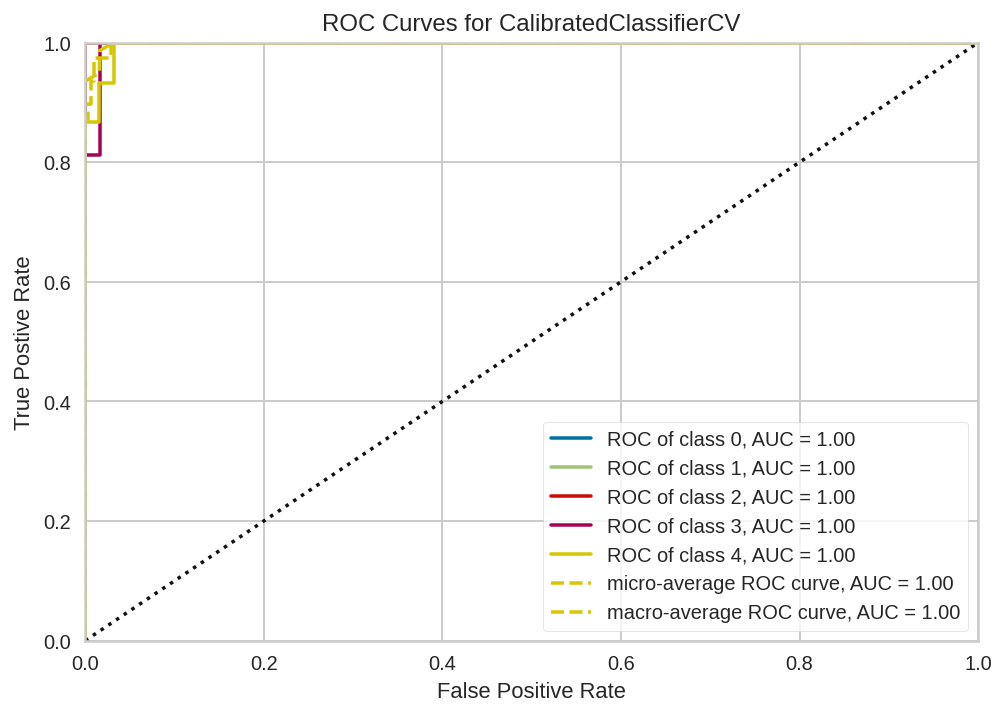

In [ ]:
plot_model(calibrated_model, plot='auc')

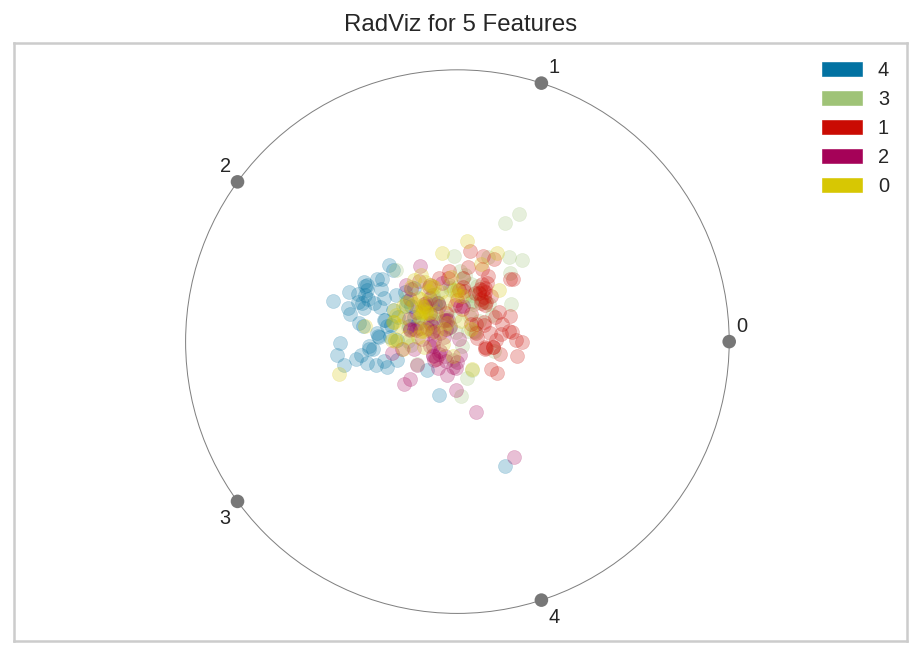

In [ ]:
plot_model(calibrated_model, plot='dimension')

In [ ]:
plot_model(calibrated_model, plot='pr')

IntProgress(value=0, description='Processing: ', max=5)

In [ ]:
plot_model(calibrated_model, plot='confusion_matrix')

In [ ]:
plot_model(calibrated_model, plot='boundary')

In [ ]:
plot_model(calibrated_model, plot='error')